In [2]:
import numpy as np
import matplotlib.pyplot as plt
import PIL
import qiskit

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.ibmq import least_busy

from PIL import Image

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2022-10-06 09:14:29,281: Credentials are already in use. The existing account in the session will be replaced.


In [3]:
import sys
!{sys.executable} -m pip install mitiq

In [4]:
# Importing mitiq and curve fitting
import mitiq
from mitiq import zne

from scipy.optimize import curve_fit

In [5]:
# Loading our image in the Quantum State
test_image = Image.open('clock_test_image_8x8.tif')
np_test_image = np.array(test_image)

# We need to do this so that we take only a single channel of the color data in the .tif image
test_image_final = []
for row in np_test_image:
    for pixel in row:
        test_image_final.append( pixel[0] / 256)

np_test_image = np.array(test_image_final)
np_test_image = np_test_image.reshape((8,8))
print("Original Image Pixel values: ")
print(np_test_image)


Original Image Pixel values: 
[[0.734375   0.7890625  0.80859375 0.8203125  0.828125   0.81640625
  0.80859375 0.77734375]
 [0.79296875 0.859375   0.87109375 0.87890625 0.890625   0.90234375
  0.890625   0.859375  ]
 [0.84375    0.890625   0.89453125 0.90625    0.859375   0.6328125
  0.77734375 0.90234375]
 [0.86328125 0.8984375  0.8984375  0.91796875 0.7734375  0.31640625
  0.453125   0.94140625]
 [0.89453125 0.9375     0.91796875 0.91796875 0.8203125  0.26171875
  0.4375     0.96875   ]
 [0.68359375 0.51953125 0.6953125  0.953125   0.734375   0.3359375
  0.49609375 0.65625   ]
 [0.5625     0.5390625  0.52734375 0.99609375 0.4140625  0.16796875
  0.22265625 0.33203125]
 [0.61328125 0.6171875  0.71484375 0.90625    0.73046875 0.55859375
  0.5625     0.578125  ]]


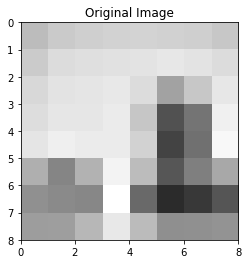

Normalized Image Pixel values: 
[[0.12184001 0.1309132  0.13415363 0.13609788 0.13739405 0.1354498
  0.13415363 0.12896894]
 [0.13156128 0.14257873 0.14452299 0.14581916 0.14776341 0.14970767
  0.14776341 0.14257873]
 [0.13998639 0.14776341 0.1484115  0.15035575 0.14257873 0.10498979
  0.12896894 0.14970767]
 [0.14322682 0.14905958 0.14905958 0.15230001 0.12832086 0.0524949
  0.07517788 0.15618852]
 [0.1484115  0.15554043 0.15230001 0.15230001 0.13609788 0.0434217
  0.07258554 0.16072512]
 [0.1134149  0.08619532 0.11535916 0.15813278 0.12184001 0.05573532
  0.08230681 0.1088783 ]
 [0.09332426 0.08943575 0.08749149 0.16526171 0.06869703 0.02786766
  0.03694085 0.05508724]
 [0.10174937 0.10239745 0.11859958 0.15035575 0.12119192 0.09267618
  0.09332426 0.0959166 ]]


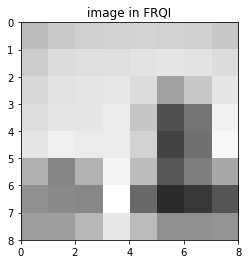

In [6]:
# Function to plot our image
def plot_image8x8(img, title: str):
    plt.title(title)
    plt.imshow(img, extent=[0, 8, 8, 0], vmin=0, vmax=1, cmap='gray')
    plt.show()
    
plot_image8x8(np_test_image, "Original Image")   

# We need to normalize our input image before passing it as the input quantum state.
def normalize(array):
    rms = np.sqrt(np.sum(np.sum(array**2)))
    ret_array = []
    for i in array:
        ret_array.append( (i * (1/rms)) )
    
    npret_array = np.array(ret_array)
    return npret_array
    
def plot_image8x8_denormalized(image, true_image, true_image_normalized, title: str):
    normalization_factor = 0.0
    for x in range(8):
        for y in range(8):
            normalization_factor += (true_image_normalized[y][x] / true_image[y][x])
    
    #The average normalization factor, to account for floating point errors.
    normalization_factor /= (8**2)
    
    image_plot = image / normalization_factor
    
    plt.title(title)
    plt.imshow(image_plot, extent=[0, 8, 8, 0], vmin=0, vmax=1, cmap='gray')
    plt.show()
    

np_test_image_normalized = normalize(np_test_image)
print("Normalized Image Pixel values: ")
print(np_test_image_normalized)

plot_image8x8_denormalized(np_test_image_normalized, np_test_image, np_test_image_normalized, 'image in FRQI')

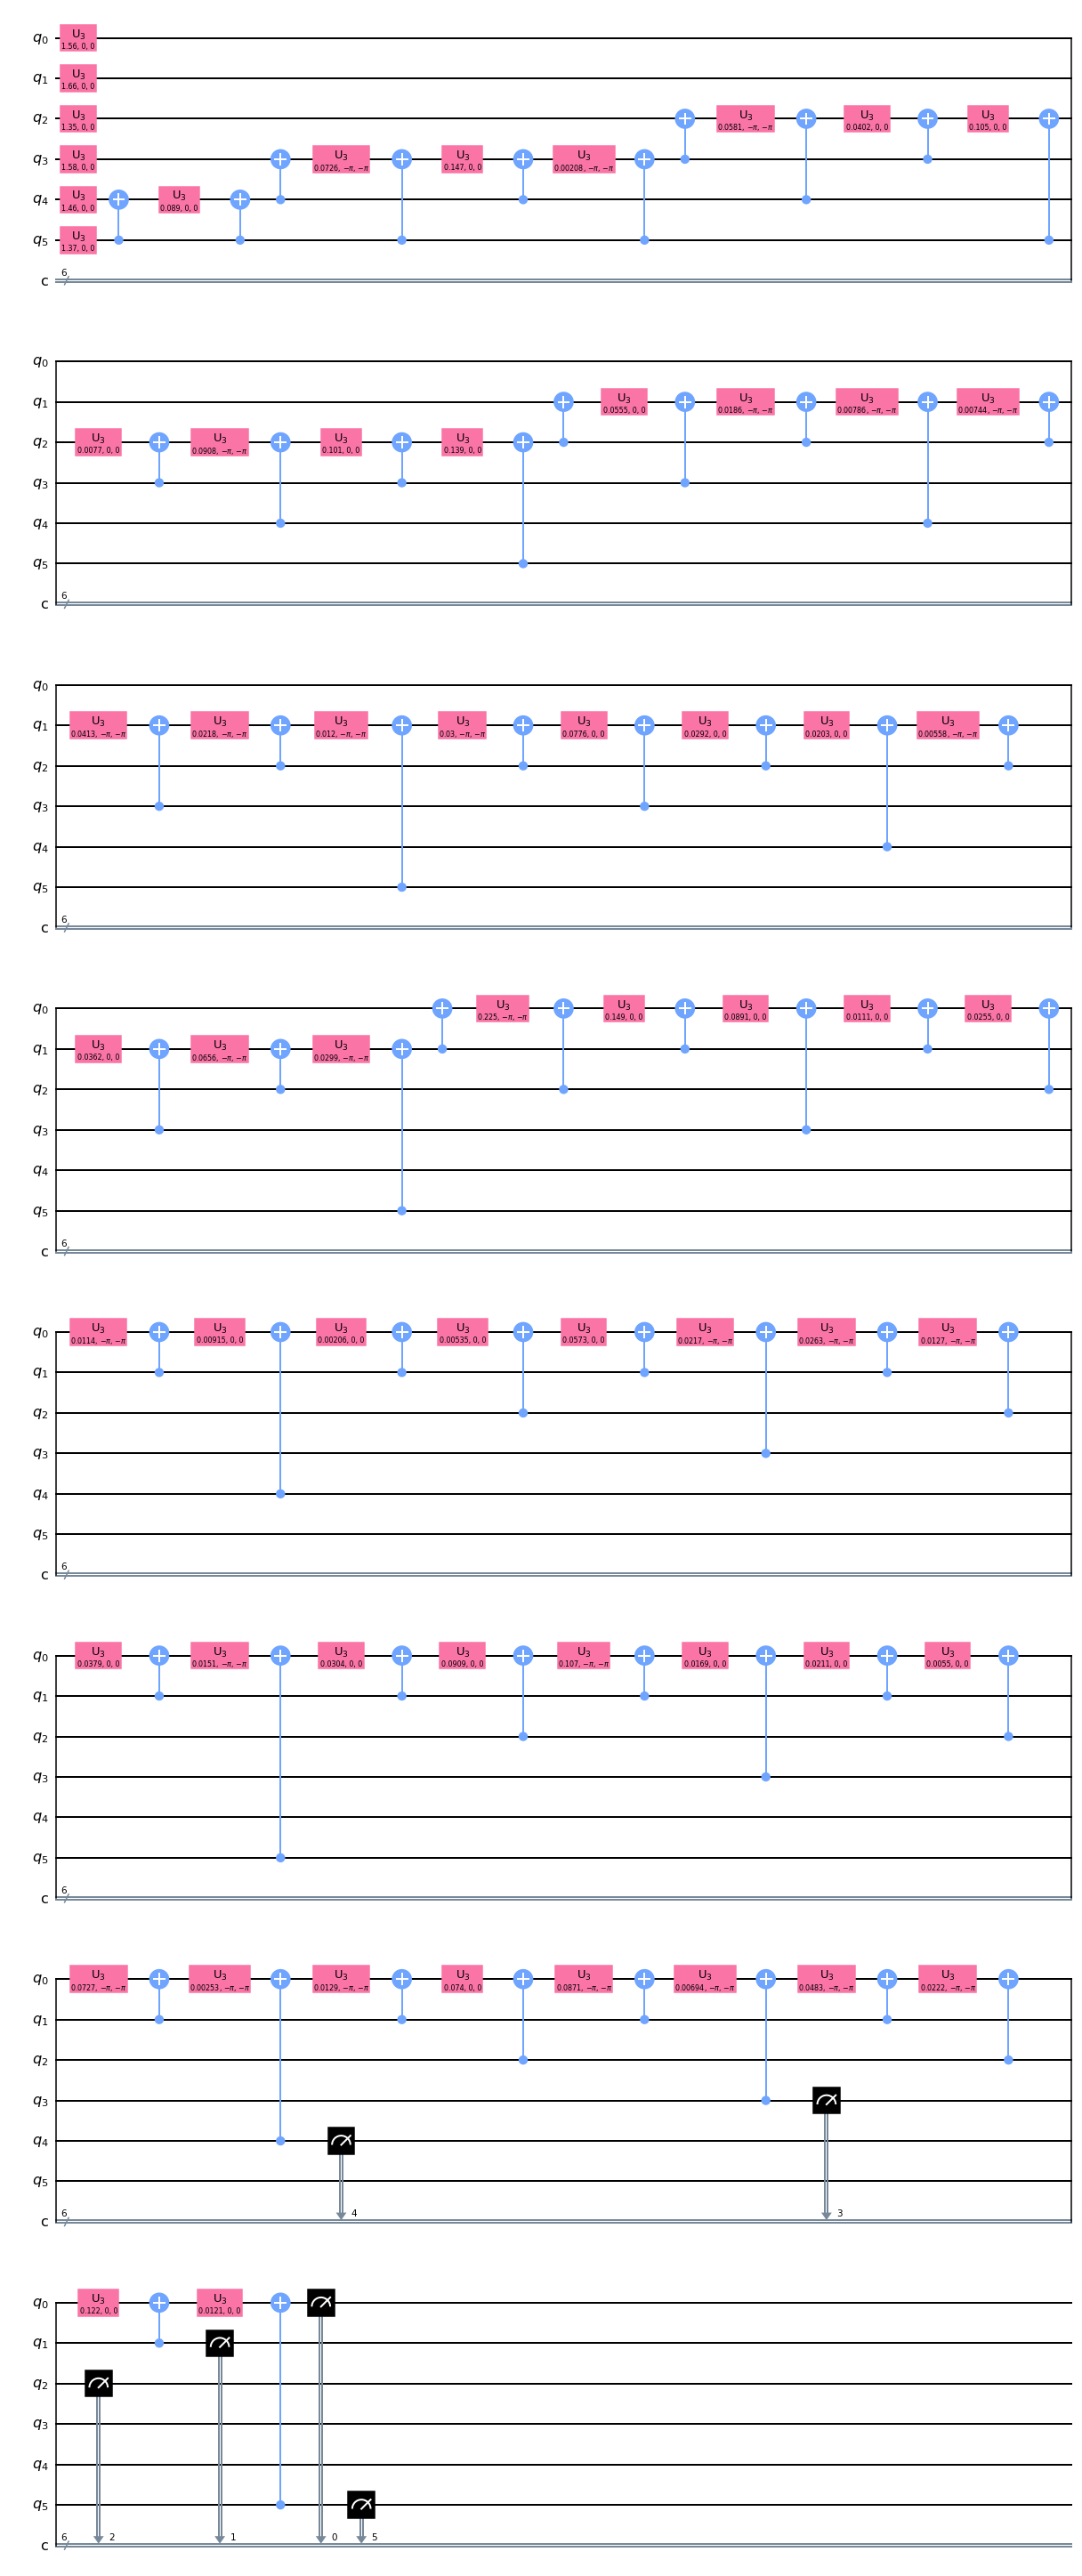

In [7]:
# Our Quantum Circuit that initializes the FRQI image
qc_image = QuantumCircuit(6,6)

qc_image.initialize(np_test_image_normalized.reshape(8**2))

qc_image.measure(range(6), range(6))

#qc_image = qc_image.decompose().decompose().decompose().decompose().decompose().decompose().decompose()
qc_image = qiskit.compiler.transpile(qc_image, basis_gates=["u1", "u2", "u3", "cx"])

qc_image.draw()

Aer Simulator Output Image Pixel Values: 
[[0.2770379  0.29197603 0.29874738 0.28504386]
 [0.29453353 0.30248967 0.06123724 0.31104662]
 [0.09082951 0.31424513 0.16881943 0.31064449]
 [0.14491377 0.30618622 0.14230249 0.14747881]]


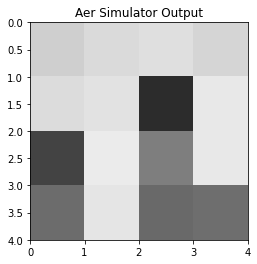

In [21]:
simulator_output = [0.2770379, 0.29197603, 0.29874738, 0.28504386,
 0.29453353, 0.30248967, 0.06123724, 0.31104662,
 0.09082951, 0.31424513, 0.16881943, 0.31064449,
 0.14491377, 0.30618622, 0.14230249, 0.14747881]
np_simulator_output = np.array(simulator_output).reshape((4,4))
print("Aer Simulator Output Image Pixel Values: ")
print(np_simulator_output)

plot_image4x4_denormalized(np_simulator_output, np_test_image, np_test_image_normalized, 'Aer Simulator Output')

In [8]:
# Calculating Error:
def un_normalize(true_image, true_image_normalized, image, n):
    normalization_factor = 0.0
    for x in range(n):
        for y in range(n):
            normalization_factor += (true_image_normalized[y][x] / true_image[y][x])
    
    #The average normalization factor, to account for floating point errors.
    normalization_factor /= (n**2)
    
    image = image / normalization_factor
    return image

def rmse_image_error(true_image, error_image, n):
    rms_error = 0.0
    for y in range(n):
        for x in range(n):
            rms_error += ((true_image[y][x] - error_image[y][x]) ** 2)
            
    rms_error = np.sqrt(rms_error)
    return (rms_error / (n**2))

In [9]:
# Routines to plot errors and extrapolations associated with each pixel
def linear_function(x, a, b):
    return a + (b * x)

def plot_pixel_error_linear(scale_factors, expectation_values, test_image_normalized, x, y, n):
    plt.xlim([0, (int(scale_factors[-1]) + 1)])
    plt.ylim([0,1])

    scale_factors_fitted = np.linspace(0, len(scale_factors), 100)

    plt.scatter(scale_factors, expectation_values[x + (y * n)], label="Output data")
    param, param_cov = curve_fit(linear_function, scale_factors, expectation_values[x + (y * n)])
    
    scale_factors_fitted_output = []
    for x_output in scale_factors_fitted:
        scale_factors_fitted_output.append(linear_function(x_output, param[0], param[1]))
        
    np_scale_factors_fitted_output = np.array(scale_factors_fitted_output)
    plt.plot(scale_factors_fitted, np_scale_factors_fitted_output, label="Extrapolation" )

    plt.scatter(0, linear_function(0, param[0], param[1]), label="ZNE Extrapolated Output")
    plt.scatter(0, test_image_normalized[y][x], label="Expected/True Output")

    plt.title("Pixel Error Data for (" + str(x) + ", " + str(y) + ")")
    plt.legend()
    plt.show()

In [16]:
# EDIT THIS CELL TO RUN AN EXPERIMENT!

# scale_factors is an array of noise multipliers
scale_factors = [1., 2., 3., 4., 5., 6., 7., 8., 9., 10.]
folded_circuits = [
        mitiq.zne.scaling.folding.fold_all(
        qc_image, scale) for scale in scale_factors
]

# Number of shots to run
shots = 100000

# Running on actual Quantum Hardware:
IBMQ.load_account()
provider = IBMQ.get_provider(hub="ibm-q-iitmadras", group="mphasis-iitm", project="default")
backend_kolkata = provider.get_backend("ibmq_mumbai")
print("Chosen Backend: ", backend_kolkata)

job = qiskit.execute(
   experiments=folded_circuits,
   backend=backend_kolkata,
   optimization_level=0,  # We're adding our own error, so we don't want qiskit to optimize anything!
   shots=shots
)

# Note the backend and Job_ID used!

ibmqfactory.load_account:WARNING:2022-10-06 10:08:02,447: Credentials are already in use. The existing account in the session will be replaced.


Chosen Backend:  ibmq_mumbai


In [13]:
# Copy the backend and Job_ID in this cell:
# Backend: ibmq_kolkata Job_ID: 633d5c7d82966609e3d01ceb

# ibmq_kolkata is under maintenance, we're going to try using ibmq_mumbai,
# backend: ibmq_mumbai,  Job_ID: 633ea7312728ecb4bbfb6cef
IBMQ.load_account()
provider = IBMQ.get_provider(hub="ibm-q-iitmadras", group="mphasis-iitm", project="default")
backend_kolkata = provider.get_backend("ibmq_mumbai")
kolkata_job = backend_kolkata.retrieve_job('633ea7312728ecb4bbfb6cef')

print(kolkata_job)

ibmqfactory.load_account:WARNING:2022-10-06 10:05:40,957: Credentials are already in use. The existing account in the session will be replaced.


In [14]:
# This code will organize the data in the way we want. 
# NOTE: THIS CODE WAS WRITTEN FOR A 8X8 IMAGE. I HAVE HARD CODED 64 INTO THE CODE.
# WE HAVE TO CHANGE THE RENDERING ROUTINES AND THE QUANTUMCIRCUIT ITSELF FOR LARGER IMAGES
get_bin = lambda x, n: format(x, 'b').zfill(n)

def linear_function(x, a, b):
    return a + (b * x)

zne_output = []

all_counts = [kolkata_job.result().get_counts(i) for i in range(len(folded_circuits))]
expectation_values = []
for i in range(64):
    expectation_values.append([np.sqrt((counts.get(get_bin(i, 6)) / shots)) for counts in all_counts])
    
for i in range(64):
    param, param_cov = curve_fit(linear_function, scale_factors, expectation_values[i])
    zne_output.append(linear_function(0, param[0], param[1]))
    
np_zne_output = np.array(zne_output).reshape((8,8))

kolkata_output = []
for i in range(64):
    kolkata_output.append(expectation_values[i][0])
np_kolkata_output = np.array(kolkata_output).reshape((8,8))

IBMQ_Kolkata Output Image Pixels:
[[0.21863211 0.2007486  0.13747727 0.13674794 0.17378147 0.17464249
  0.11874342 0.11489125]
 [0.19723083 0.18601075 0.13784049 0.12845233 0.17029386 0.16278821
  0.12369317 0.117047  ]
 [0.11445523 0.10723805 0.07615773 0.07348469 0.10198039 0.08660254
  0.05477226 0.06708204]
 [0.1        0.1029563  0.07483315 0.0663325  0.08717798 0.08485281
  0.06480741 0.05385165]
 [0.18841444 0.19672316 0.13638182 0.124499   0.16062378 0.16703293
  0.11489125 0.12041595]
 [0.18248288 0.18734994 0.12961481 0.13190906 0.16309506 0.16703293
  0.1034408  0.12041595]
 [0.10816654 0.09899495 0.0728011  0.07937254 0.09110434 0.08485281
  0.0678233  0.06403124]
 [0.10440307 0.09539392 0.07211103 0.07071068 0.08062258 0.083666
  0.05385165 0.05656854]]


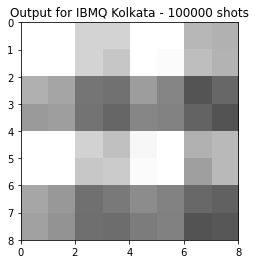

IBMQ_Kolkata (w/ ZNE) Output Image Pixels:
[[0.26463422 0.26184833 0.19803444 0.19520231 0.21341891 0.2141937
  0.16653223 0.16219885]
 [0.1746348  0.16703268 0.1381708  0.12521094 0.14669772 0.14071009
  0.11358802 0.11294254]
 [0.11299695 0.1086046  0.08565876 0.08137176 0.10617546 0.1024986
  0.07659183 0.07846359]
 [0.0797851  0.08199091 0.06125929 0.05276022 0.06990077 0.07481294
  0.05103928 0.05199359]
 [0.18177906 0.18604473 0.13942978 0.13287091 0.16450291 0.16635548
  0.12927296 0.12799942]
 [0.1356705  0.13690649 0.10325557 0.10908461 0.12639387 0.11447873
  0.08823697 0.09462278]
 [0.08879221 0.08330346 0.05410725 0.05918686 0.08470485 0.08317493
  0.06507834 0.06229465]
 [0.06682029 0.0605346  0.04890137 0.05054672 0.05959085 0.05802251
  0.04258919 0.04399175]]


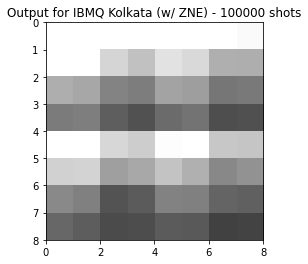

In [15]:
# Plotting the outputs:
print("IBMQ_Kolkata Output Image Pixels:")
print(np_kolkata_output)
plot_image8x8_denormalized(np_kolkata_output, np_test_image, np_test_image_normalized, 'Output for IBMQ Kolkata - 100000 shots')

print("IBMQ_Kolkata (w/ ZNE) Output Image Pixels:")
print(np_zne_output)
plot_image8x8_denormalized(np_zne_output, np_test_image, np_test_image_normalized, 'Output for IBMQ Kolkata (w/ ZNE) - 100000 shots')

In [22]:
# RUN THIS CELL!!!!
# ibmq_kolkata is under maintenance, we're going to try using ibmq_mumbai,
# backend: ibmq_mumbai,  Job_ID: 633ea91583172d68f5d199aa
IBMQ.load_account()
provider = IBMQ.get_provider(hub="ibm-q-iitmadras", group="mphasis-iitm", project="default")
backend_kolkata = provider.get_backend("ibmq_mumbai")
kolkata_job = backend_kolkata.retrieve_job('633ea91583172d68f5d199aa')

print(kolkata_job)

ibmqfactory.load_account:WARNING:2022-10-06 10:20:53,910: Credentials are already in use. The existing account in the session will be replaced.


In [24]:
# This code will organize the data in the way we want. 
# NOTE: THIS CODE WAS WRITTEN FOR A 8X8 IMAGE. I HAVE HARD CODED 64 INTO THE CODE.
# WE HAVE TO CHANGE THE RENDERING ROUTINES AND THE QUANTUMCIRCUIT ITSELF FOR LARGER IMAGES
get_bin = lambda x, n: format(x, 'b').zfill(n)

def linear_function(x, a, b):
    return a + (b * x)

zne_output = []

all_counts = [kolkata_job.result().get_counts(i) for i in range(len(folded_circuits))]
expectation_values = []
for i in range(64):
    expectation_values.append([np.sqrt((counts.get(get_bin(i, 6)) / shots)) for counts in all_counts])
    
for i in range(64):
    param, param_cov = curve_fit(linear_function, scale_factors, expectation_values[i])
    zne_output.append(linear_function(0, param[0], param[1]))
    
np_zne_output = np.array(zne_output).reshape((8,8))

kolkata_output = []
for i in range(64):
    kolkata_output.append(expectation_values[i][0])
np_kolkata_output = np.array(kolkata_output).reshape((8,8))

IBMQ Kolkata Output Image Pixels:
[[0.20151923 0.1909712  0.14916434 0.1440486  0.16801786 0.16893786
  0.13099618 0.12672806]
 [0.11484773 0.12037442 0.08809086 0.09176056 0.10310189 0.0997998
  0.07589466 0.07816649]
 [0.18485129 0.17866169 0.13733172 0.13431307 0.15652476 0.16251154
  0.12457929 0.1175585 ]
 [0.1077961  0.11256109 0.08372574 0.08246211 0.09513149 0.09305912
  0.07436397 0.07099296]
 [0.17944358 0.18036075 0.13896043 0.13364131 0.16766037 0.15083103
  0.11760102 0.11484773]
 [0.1174734  0.10397115 0.08631338 0.08264381 0.09396808 0.09252027
  0.07148426 0.06848357]
 [0.17216271 0.16798809 0.12755391 0.12771061 0.15264338 0.14366628
  0.10963576 0.11045361]
 [0.1077033  0.10074721 0.07993748 0.07463243 0.08860023 0.09159694
  0.0697137  0.06870226]]


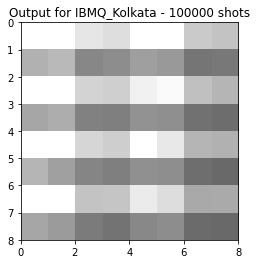

IBMQ Kolkata (w/ ZNE) Output Image Pixels:
[[0.23082316 0.21330553 0.18258165 0.17034296 0.17676384 0.17992304
  0.14590312 0.13735844]
 [0.15012127 0.14438897 0.11872    0.12095403 0.11860265 0.11569852
  0.09150133 0.09157137]
 [0.15294405 0.14859629 0.12664135 0.11894727 0.12623399 0.13541743
  0.10806003 0.10183733]
 [0.10197198 0.09518042 0.08186236 0.08301465 0.08461237 0.08022378
  0.06943059 0.06658159]
 [0.18270409 0.17986439 0.14568786 0.14419017 0.16372822 0.14388718
  0.11982294 0.11978729]
 [0.12259603 0.11726801 0.09975352 0.09297323 0.10057638 0.09946239
  0.07886678 0.07660426]
 [0.13322824 0.13301787 0.10596661 0.1090785  0.12479248 0.10898498
  0.09104289 0.09215543]
 [0.08619046 0.08675333 0.07395352 0.06849755 0.07319529 0.07487822
  0.06117783 0.05788128]]


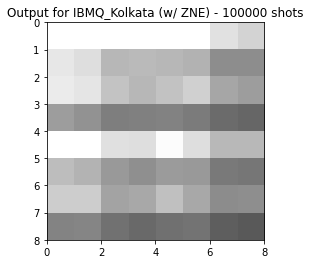

In [25]:
# Plotting the outputs:
print("IBMQ Kolkata Output Image Pixels:")
print(np_kolkata_output)
plot_image8x8_denormalized(np_kolkata_output, np_test_image, np_test_image_normalized, 'Output for IBMQ_Kolkata - 100000 shots')

print("IBMQ Kolkata (w/ ZNE) Output Image Pixels:")
print(np_zne_output)
plot_image8x8_denormalized(np_zne_output, np_test_image, np_test_image_normalized, 'Output for IBMQ_Kolkata (w/ ZNE) - 100000 shots')

In [26]:
# Calculating and Displaying the RMSE errors:
rmse_kolkata = rmse_image_error(np_test_image, un_normalize(np_test_image, np_test_image_normalized, np_kolkata_output, 8), 8) 
rmse_kolkata_zne = rmse_image_error(np_test_image, un_normalize(np_test_image, np_test_image_normalized, np_zne_output, 8), 8) 
print("Simulator error (100000 shots): ", (rmse_kolkata * 100), "% per pixel")
print("Simulator (with ZNE) error (100000 shots): ", (rmse_kolkata_zne * 100), "% per pixel")

Simulator error (100000 shots):  3.5985101546455525 % per pixel
Simulator (with ZNE) error (100000 shots):  3.3487569029058224 % per pixel


In [28]:
# EDIT THIS CELL TO RUN AN EXPERIMENT!

# scale_factors is an array of noise multipliers
scale_factors = [1., 2., 3., 4., 5., 6., 7., 8., 9., 10.]
folded_circuits = [
        mitiq.zne.scaling.folding.fold_all(
        qc_image, scale) for scale in scale_factors
]

# Number of shots to run
shots = 100000

# Running on actual Quantum Hardware:
IBMQ.load_account()
provider = IBMQ.get_provider(hub="ibm-q-iitmadras", group="mphasis-iitm", project="default")
backend_kolkata = Aer.get_backend("aer_simulator")
print("Chosen Backend: ", backend_kolkata)

job = qiskit.execute(
   experiments=folded_circuits,
   backend=backend_kolkata,
   optimization_level=0,  # We're adding our own error, so we don't want qiskit to optimize anything!
   shots=shots
)

# Note the backend and Job_ID used!

ibmqfactory.load_account:WARNING:2022-10-06 10:30:10,998: Credentials are already in use. The existing account in the session will be replaced.


Chosen Backend:  aer_simulator


In [29]:
# This code will organize the data in the way we want. 
# NOTE: THIS CODE WAS WRITTEN FOR A 8X8 IMAGE. I HAVE HARD CODED 64 INTO THE CODE.
# WE HAVE TO CHANGE THE RENDERING ROUTINES AND THE QUANTUMCIRCUIT ITSELF FOR LARGER IMAGES
get_bin = lambda x, n: format(x, 'b').zfill(n)

def linear_function(x, a, b):
    return a + (b * x)

zne_output = []

all_counts = [job.result().get_counts(i) for i in range(len(folded_circuits))]
expectation_values = []
for i in range(64):
    expectation_values.append([np.sqrt((counts.get(get_bin(i, 6)) / shots)) for counts in all_counts])
    
for i in range(64):
    param, param_cov = curve_fit(linear_function, scale_factors, expectation_values[i])
    zne_output.append(linear_function(0, param[0], param[1]))
    
np_zne_output = np.array(zne_output).reshape((8,8))

kolkata_output = []
for i in range(64):
    kolkata_output.append(expectation_values[i][0])
np_kolkata_output = np.array(kolkata_output).reshape((8,8))

Aer Simulator Output Image Pixels:
[[0.12312595 0.13111064 0.13435029 0.13798551 0.13605146 0.13243867
  0.13319159 0.1283355 ]
 [0.12957623 0.14422205 0.14498276 0.1456022  0.15036622 0.15165751
  0.15069837 0.14408331]
 [0.13707662 0.14996666 0.14764823 0.15488706 0.14060583 0.10521407
  0.12860793 0.15149257]
 [0.14642404 0.14778363 0.14866069 0.15026643 0.12684636 0.05282045
  0.07576279 0.15524175]
 [0.14686729 0.15491933 0.15016657 0.1520855  0.13390295 0.04123106
  0.07071068 0.16220358]
 [0.11211601 0.08944272 0.11661904 0.1570987  0.12251531 0.05495453
  0.08024961 0.11022704]
 [0.09170605 0.08797727 0.08820431 0.16601205 0.06913754 0.02408319
  0.03924283 0.05761944]
 [0.10059821 0.10193135 0.11903781 0.14956604 0.11874342 0.09284396
  0.09359487 0.09710819]]


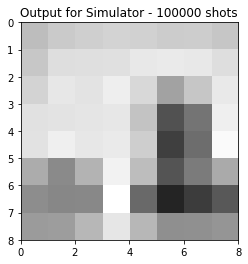

Aer Simulator (w/ ZNE) Output Image Pixels:
[[0.12391171 0.13167682 0.13571256 0.13565198 0.1371629  0.13377243
  0.13446237 0.12881717]
 [0.13117568 0.14285116 0.14459179 0.14600729 0.14983065 0.15100675
  0.15008986 0.1426882 ]
 [0.13902183 0.15018071 0.14846728 0.15195575 0.14103231 0.10432542
  0.12689334 0.15086186]
 [0.14509501 0.14646916 0.14922144 0.15155999 0.1271307  0.05172712
  0.0750273  0.15551275]
 [0.14659634 0.15407984 0.1518035  0.15045126 0.13453951 0.04364135
  0.07212636 0.16031651]
 [0.11263938 0.08786593 0.11583291 0.15917851 0.12261971 0.05427959
  0.08239197 0.11097807]
 [0.09263452 0.08867743 0.08900473 0.165575   0.06917101 0.02686516
  0.03745936 0.05690515]
 [0.10114048 0.10241311 0.11910312 0.15012686 0.11968646 0.09377192
  0.09139748 0.09530758]]


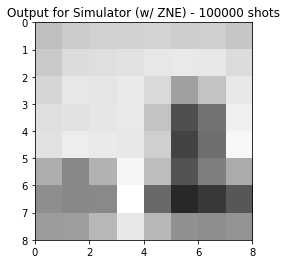

In [30]:
# Plotting the outputs:
print("Aer Simulator Output Image Pixels:")
print(np_kolkata_output)
plot_image8x8_denormalized(np_kolkata_output, np_test_image, np_test_image_normalized, 'Output for Simulator - 100000 shots')

print("Aer Simulator (w/ ZNE) Output Image Pixels:")
print(np_zne_output)
plot_image8x8_denormalized(np_zne_output, np_test_image, np_test_image_normalized, 'Output for Simulator (w/ ZNE) - 100000 shots')

In [20]:
# Calculating and Displaying the RMSE errors:
rmse_simulator = rmse_image_error(np_test_image, un_normalize(np_test_image, np_test_image_normalized, np_kolkata_output, 8), 8) 
rmse_simulator_zne = rmse_image_error(np_test_image, un_normalize(np_test_image, np_test_image_normalized, np_zne_output, 8), 8) 
print("Simulator error (100000 shots): ", (rmse_simulator * 100), "% per pixel")
print("Simulator (with ZNE) error (100000 shots): ", (rmse_simulator_zne * 100), "% per pixel")

Simulator error (100000 shots):  0.1290513871473497 % per pixel
Simulator (with ZNE) error (100000 shots):  0.08338960082774646 % per pixel


In [27]:
from skimage.metrics import structural_similarity as ssim
np_kolkata_output_unnormalized = un_normalize(np_test_image, np_test_image_normalized, np_kolkata_output, 8)
np_kolkata_zne_output_unnormalized = un_normalize(np_test_image, np_test_image_normalized, np_zne_output, 8)

ssim_kolkata = ssim(np_test_image, np_kolkata_output_unnormalized, data_range=np_kolkata_output_unnormalized.max() - np_kolkata_output_unnormalized.min())
ssim_kolkata_zne = ssim(np_test_image, np_kolkata_zne_output_unnormalized, data_range=np_kolkata_zne_output_unnormalized.max() - np_kolkata_zne_output_unnormalized.min())
print("IBMQ_Kolkata SSIM: ", (ssim_kolkata * 100), "% Similar")
print("IBM Kolkata (w/ ZNE) SSIM: ", (ssim_kolkata_zne * 100), "% Similar")

IBMQ_Kolkata SSIM:  4.289483227530384 % Similar
IBM Kolkata (w/ ZNE) SSIM:  23.604527987683273 % Similar


In [ ]:
from skimage.metrics import structural_similarity as ssim
np_simulator_output_unnormalized = un_normalize(np_test_image, np_test_image_normalized, np_kolkata_output, 8)
np_simulator_zne_output_unnormalized = un_normalize(np_test_image, np_test_image_normalized, np_zne_output, 8)

ssim_simulator = ssim(np_test_image, np_simulator_output_unnormalized, data_range=np_simulator_output_unnormalized.max() - np_simulator_output_unnormalized.min())
ssim_simulator_zne = ssim(np_test_image, np_simulator_zne_output_unnormalized, data_range=np_simulator_zne_output_unnormalized.max() - np_simulator_zne_output_unnormalized.min())
print("Simulator SSIM: ", (ssim_simulator * 100), "% Similar")
print("Simulator (w/ ZNE) SSIM: ", (ssim_simulator_zne * 100), "% Similar")

In [ ]:
# Plotting all of the errors and extrapolations for each pixel
for y in range(8):
    for x in range(8):
        plot_pixel_error_linear(scale_factors, expectation_values, np_test_image_normalized, x, y, 4)